# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both
import pickle

In [2]:
#Start Calculating the Running Time
Start = time.time()

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

## Create and Run `ForestModel` instance

In [4]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris_test',
                            # model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

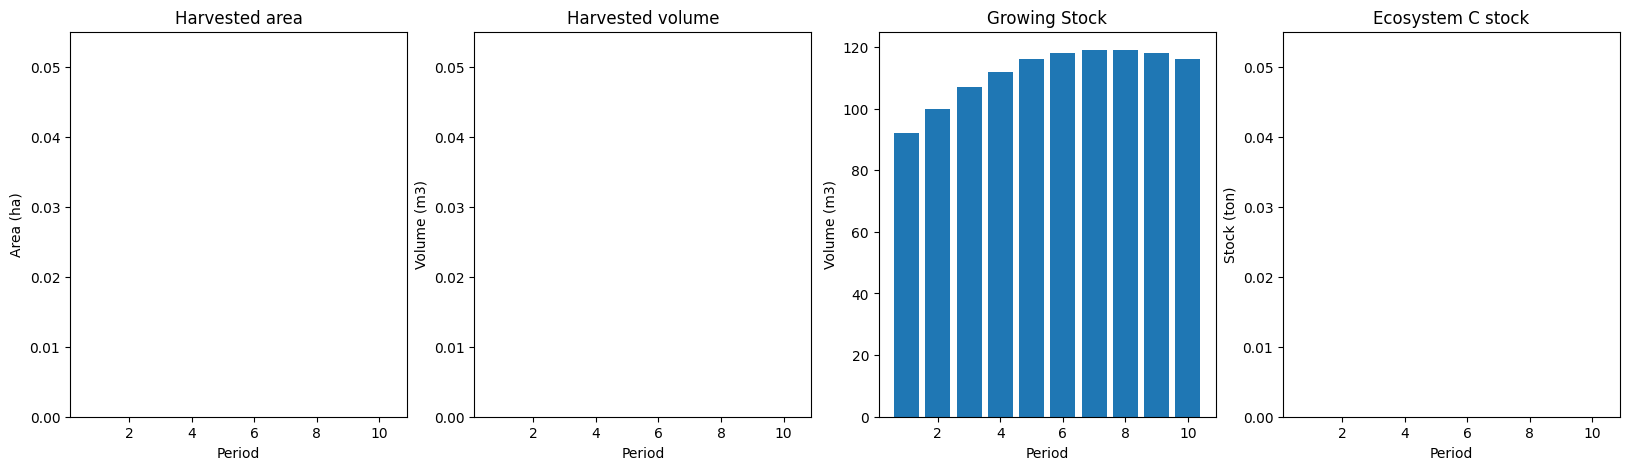

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]


npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

# decay_emissions_fluxes = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]
ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
# fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
# gross_growth = grossgrowth_ag + grossgrowth_bg
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,60.732200,115.923866,176.656066,0.000000,0.000000,0.000000
1,61.009575,116.039083,177.048658,2.680478,3.073070,-0.392591
2,61.286626,116.155297,177.441923,2.685132,3.078397,-0.393265
3,61.563356,116.272596,177.835952,2.689677,3.083707,-0.394030
4,61.839768,116.391052,178.230820,2.694133,3.089000,-0.394867
...,...,...,...,...,...,...
96,68.519663,128.512642,197.032305,2.888287,2.947788,-0.059501
97,68.452335,128.637845,197.090180,2.888616,2.946491,-0.057875
98,68.384991,128.761477,197.146468,2.888904,2.945193,-0.056288


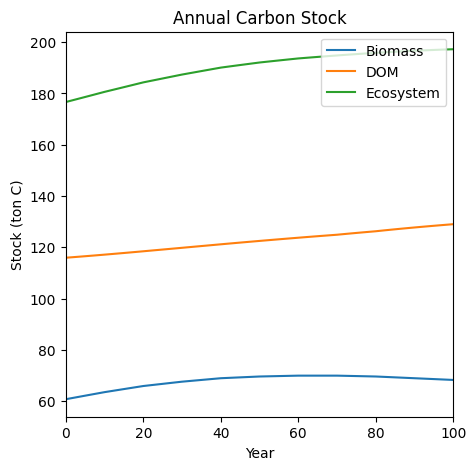

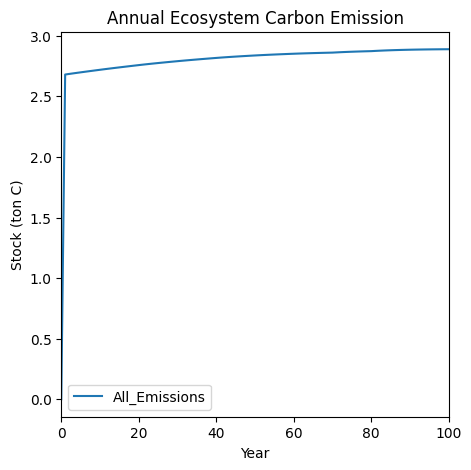

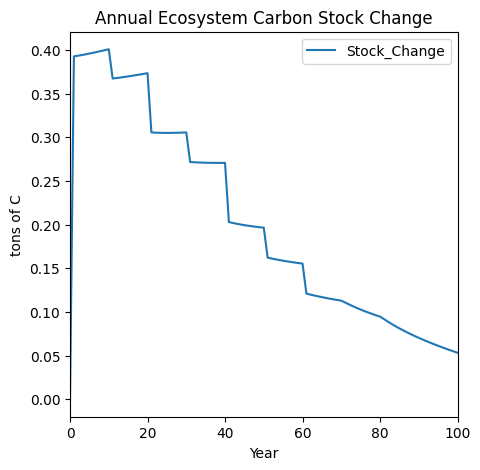

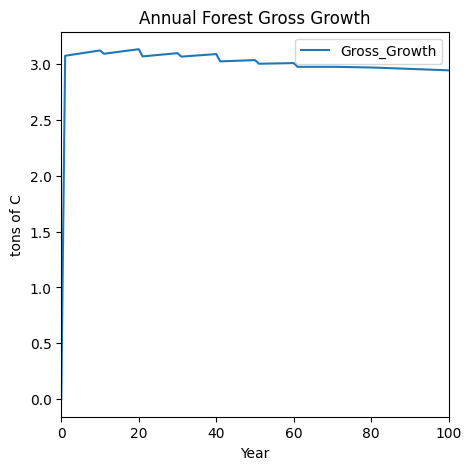

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,1,7,100,7,7,softwood,FALSE,100,1.0,0,0,fire,fire


In [16]:
# Set Age and Area to 1 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,1,7,100,7,7,softwood,FALSE,0,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [17]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [18]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

In [19]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [20]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [21]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products,dtype_key
0,1,0,tsa04,1,7,100,7,7,softwood,1.0,...,29.725512,19.634594,0.0,0.0,5286.445926,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
1,1,1,tsa04,1,7,100,7,7,softwood,1.0,...,28.471822,16.958521,0.0,0.0,5289.602955,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
2,1,2,tsa04,1,7,100,7,7,softwood,1.0,...,27.271019,14.649093,0.0,0.0,5292.541272,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
3,1,3,tsa04,1,7,100,7,7,softwood,1.0,...,26.120890,12.658623,0.0,0.0,5295.310824,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
4,1,4,tsa04,1,7,100,7,7,softwood,1.0,...,25.019322,10.944674,0.0,0.0,5297.948933,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,96,tsa04,1,7,100,7,7,softwood,1.0,...,2.272871,1.436905,0.0,0.0,5519.525872,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
97,1,97,tsa04,1,7,100,7,7,softwood,1.0,...,2.279829,1.439922,0.0,0.0,5522.186932,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
98,1,98,tsa04,1,7,100,7,7,softwood,1.0,...,2.287511,1.442916,0.0,0.0,5524.852884,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7
99,1,99,tsa04,1,7,100,7,7,softwood,1.0,...,2.295887,1.445889,0.0,0.0,5527.523712,5.194811,46.751799,0.0,0.0,tsa04 1 7 100 7 7


In [22]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,DisturbanceCO2Production,...,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir,dtype_key
0,1,0,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
1,1,1,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
2,1,2,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
3,1,3,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
4,1,4,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,96,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
97,1,97,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
98,1,98,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7
99,1,99,tsa04,1,7,100,7,7,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tsa04 1 7 100 7 7


In [23]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [24]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [25]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0              0.000000         0.000000       0.000000   
                  1              0.000905         0.462519       0.026120   
                  2              0.005156         0.766671       0.395105   
                  3              0.014269         1.018804       0.897710   
                  4              0.029371         1.237817       1.482881   
...                                   ...              ...            ...   
                  96            22.976543         4.881163      20.702328   
                  97            23.205463         4.897155      20.742806   
                  98            23.434078         4.913102      20.783201   
                  99            23.662392         4.929004      20.823515   
                  100           23.890409         4.944861      20.863748   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 1 7 100 7 7 0                    0.000000           0.000000   
                  1                    0.062882           0.045797   
                  2                    0.151517           0.107542   
                  3                    0.253669           0.174964   
                  4                    0.365755           0.244760   
...                                         ...                ...   
                  96                   8.962234           1.818094   
                  97                   9.022871           1.820813   
                  98                   9.083449           1.823496   
                  99                   9.143967           1.826144   
                  100                  9.204425           1.828757   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
                  96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 1 7 100 7 7 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
                  96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            MediumSoil  AboveGroundSlowSoil  \
dtype_key         timestep                                    
tsa04 1 7 1

In [26]:
# Generate carbon yield curves for net emission
# c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
# c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [27]:
c_curves_f['total_emissions'] = 44/12 * c_curves_f[fluxes].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emissions'] = c_curves_f['total_emissions'] - c_curves_f['gross_growth']

In [28]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 1 7 100 7 7 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
                  96                             0.0   
                  97                             0.0   
                  98                             0.0   
                  99                             0.0   
                  100                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 1 7 100 7 7 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
                  96                             0.0                      0.0   
                  97                             0.0                      0.0   
                  98                             0.0                      0.0   
                  99                             0.0                      0.0   
                  100                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 1 7 100 7 7 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
                  96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 1 7 100 7 7 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
                  96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                              0.0             0.000000   
                  1                              0.0             3.157029   
                  2                              0.0             2.938317   
                  3                              0.0             2.769552   
                  4                              0.0             2.638109   
...                                              ...                  ...   
                  96                             0.0             2.656150   
                  97                             0.0             2.6

Curvs Calibration

In [29]:
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [30]:
with open(f'{case_study}_c_curves_p_test.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [31]:
# with open(f'{case_study}_c_curves_p_test.pkl', 'rb') as file:
#     c_curves_p = pickle.load(file)

In [32]:
with open(f'{case_study}_c_curves_f_test.pkl', 'wb') as file:
    pickle.dump(c_curves_f, file)

In [33]:
# with open(f'{case_study}_c_curves_f_test.pkl', 'rb') as file:
#     c_curves_f = pickle.load(file)

In [34]:
# Plug carbon yield curves into forest model
plugin_c_curves_both(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_emissions', 'total_emissions', 'gross_growth'])
# plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '7', '7')


In [35]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f97518df0d0>),
   ('ecosystem', <ws3.core.Curve at 0x7f974b01e020>),
   ('biomass', <ws3.core.Curve at 0x7f974b01f970>),
   ('DOM', <ws3.core.Curve at 0x7f974b01da50>),
   ('net_emissions', <ws3.core.Curve at 0x7f974b01d540>),
   ('total_emissions', <ws3.core.Curve at 0x7f974b01df90>),
   ('gross_growth', <ws3.core.Curve at 0x7f974b01d5a0>)]),
 (('?', '?', '?', '?', '?', '?'),
  'c',
  [('totvol', '_SUM(s0100)'),
   ('swdvol', '_SUM(s0100)'),
   ('hwdvol', '_SUM()')])]

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

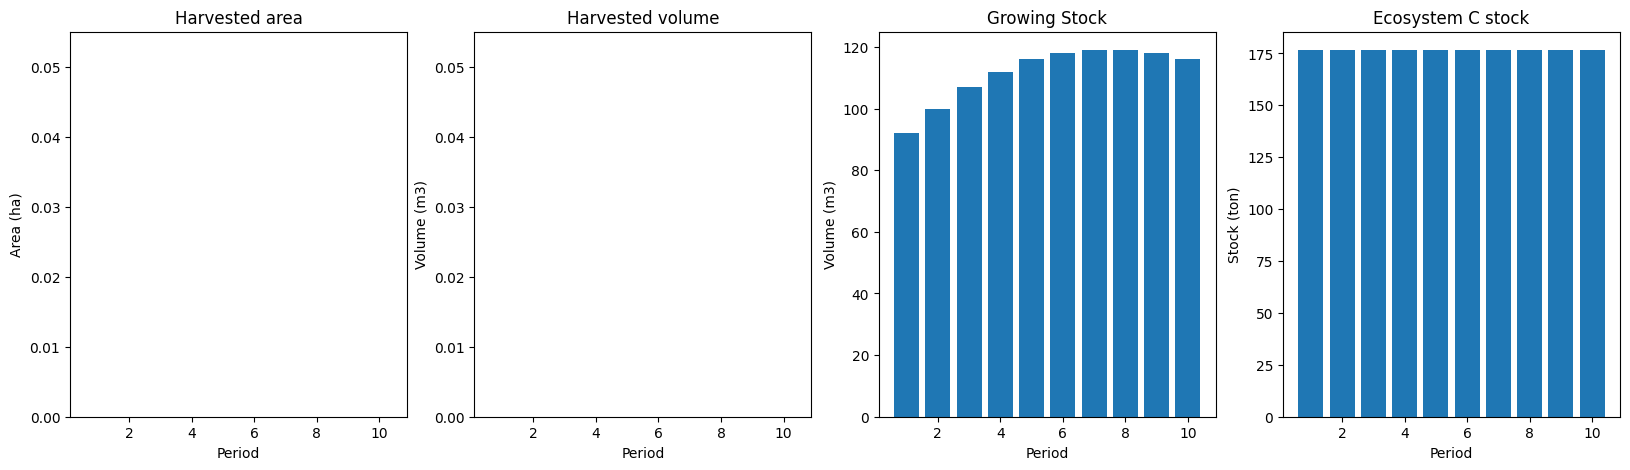

In [36]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [37]:
# softwood_volume_yname='swdvol' 
# hardwood_volume_yname='hwdvol'
# n_yield_vals=100

In [38]:
# sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [39]:
# Replace the Sit_events file in the sit tables
# sit_tables['sit_events'] = sit_events

In [40]:
# sit_events

In [41]:

# sit_tables['sit_inventory']

In [42]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change,Net_Emissions
Year,,,,,,,
0,0.000000,151.806488,151.806488,0.000000,0.000000,0.000000,0.000000
1,0.598223,148.688416,149.286639,11.575773,-2.336328,2.519849,9.239445
2,1.425991,145.871285,147.297277,10.773830,-3.479501,1.989362,7.294328
3,2.359417,143.311503,145.670920,10.155024,-4.191715,1.626357,5.963309
4,3.360585,140.974650,144.335235,9.673067,-4.775556,1.335685,4.897511
...,...,...,...,...,...,...,...
96,59.340361,115.483012,174.823373,9.739217,-11.403002,-0.453760,-1.663785
97,59.689108,115.589801,175.278909,9.757222,-11.427518,-0.455535,-1.670296
98,60.037326,115.698885,175.736211,9.775157,-11.451933,-0.457302,-1.676775


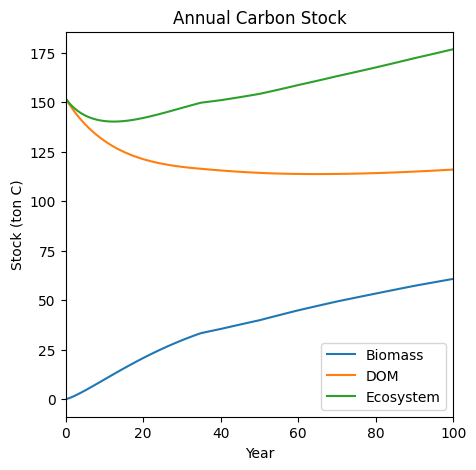

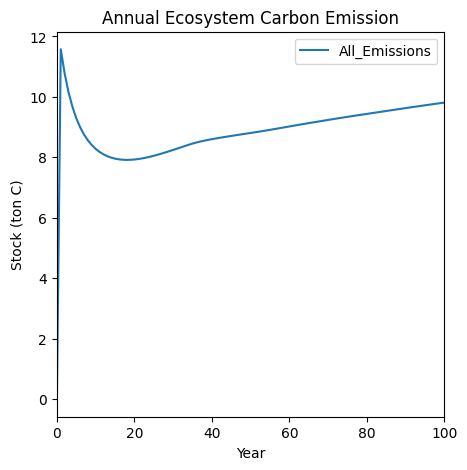

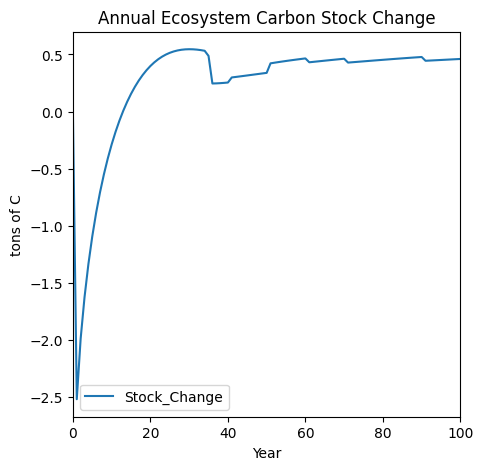

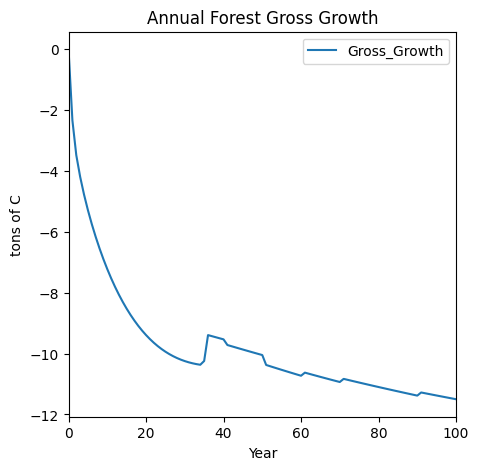

In [43]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

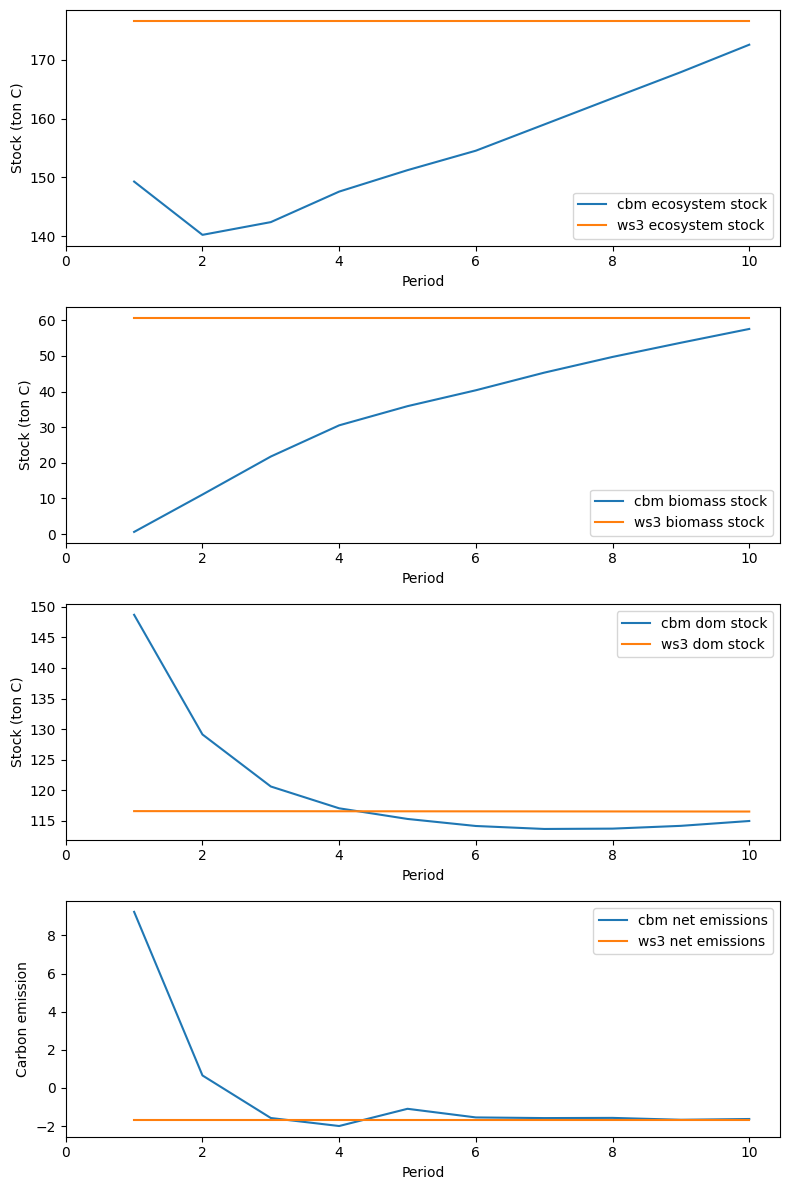

(   period  biomass_stock   dom_stock   eco_stock  ecosystem_decay_emissions  \
 0       1       0.598223  148.688416  149.286639                  11.575773   
 1       2      11.092183  129.129241  140.221424                   8.180159   
 2       3      21.765795  120.623980  142.389775                   7.943990   
 3       4      30.523953  117.058038  147.581991                   8.287426   
 4       5      35.909715  115.319723  151.229438                   8.623584   
 5       6      40.372903  114.167708  154.540611                   8.826072   
 6       7      45.316584  113.682444  158.999028                   9.043953   
 7       8      49.733983  113.736952  163.470935                   9.258627   
 8       9      53.718711  114.191854  167.910566                   9.456372   
 9      10      57.588465  114.983880  172.572345                   9.647434   
 
    gross_growth  net_emissions  eco_stock_change  
 0     -2.336328       9.239445          0.000000  
 1     -7.5265

In [44]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="individual")
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

In [45]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 1.2 minutes to run this script.
